## __Predict if Customer will honor Reservation or cancel it__

https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

In [1]:
__author__ = 'Oskar Martin Kieliger'
__email__ = 'oscar.martink1@gmail.com'
__website__ = 'oskarmk@github.io'

### __1. Frame The Problem and look at the Big Picture__

The Goal of this Project is to predict if the customer is going to honor the reservation or cancel it. This is a binary classification problem. The target variable we are trying to predict is booking_status which can take either __Canceled__ or __Not_Canceled__ values

##### __Import Libraries__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='once')

##### __Load Data & Initial Exploration__

In [3]:
# Load data
data = pd.read_csv('Data/Hotel Reservations.csv')

# Sepparate features and target variable
X_train = data.drop(['booking_status'], axis=1) # .drop -> automatically generates a copy of the original datatest
y = data['booking_status']

In [4]:
# Call .info() to see number of entries, number of features, feature names, non-null count, feature DTypes 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

- There is a total of 18 Features (Exclusing booking_status)
- There is no missing values
- 4 Features are categorical
- 14 Features are numerical

In [5]:
print('The Categorical Features are: ', list(X_train.select_dtypes(include='object').columns))
print('\n')
print('The Numerical Features are: ', list(X_train.select_dtypes(exclude='object').columns))

The Categorical Features are:  ['Booking_ID', 'type_of_meal_plan', 'room_type_reserved', 'market_segment_type']


The Numerical Features are:  ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']


In [6]:
# Let's pring out the first couple rows of data to see what the values of each feature look like
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### __2. Exploratory Data Analysis__

#### __2.1 Booking Status__

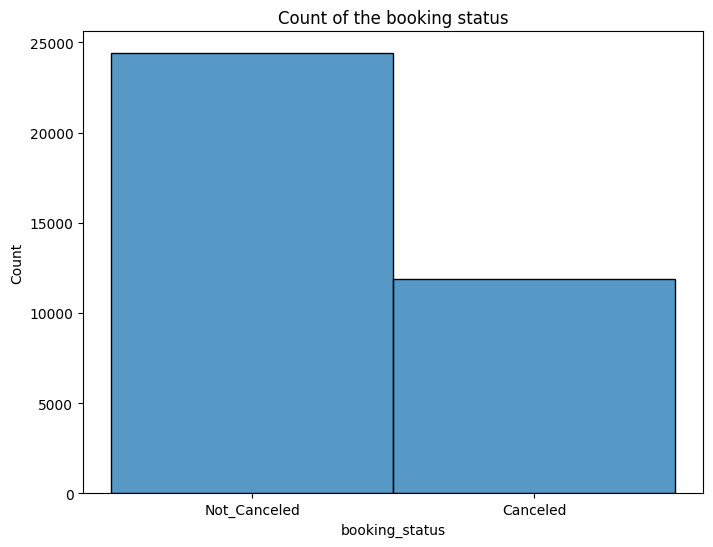

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(data=y)
title = plt.title('Count of the booking status')

In [8]:
print('Total Canceled bookings: ', y[y == 'Canceled'].count())
print('Total Not Canceled bookings: ', y[y != 'Canceled'].count())

Total Canceled bookings:  11885
Total Not Canceled bookings:  24390


#### __2.2 Numerical Features__

In [9]:
# Let's see which features have the highest correlations
corr_mat = data.corr()

<AxesSubplot: >

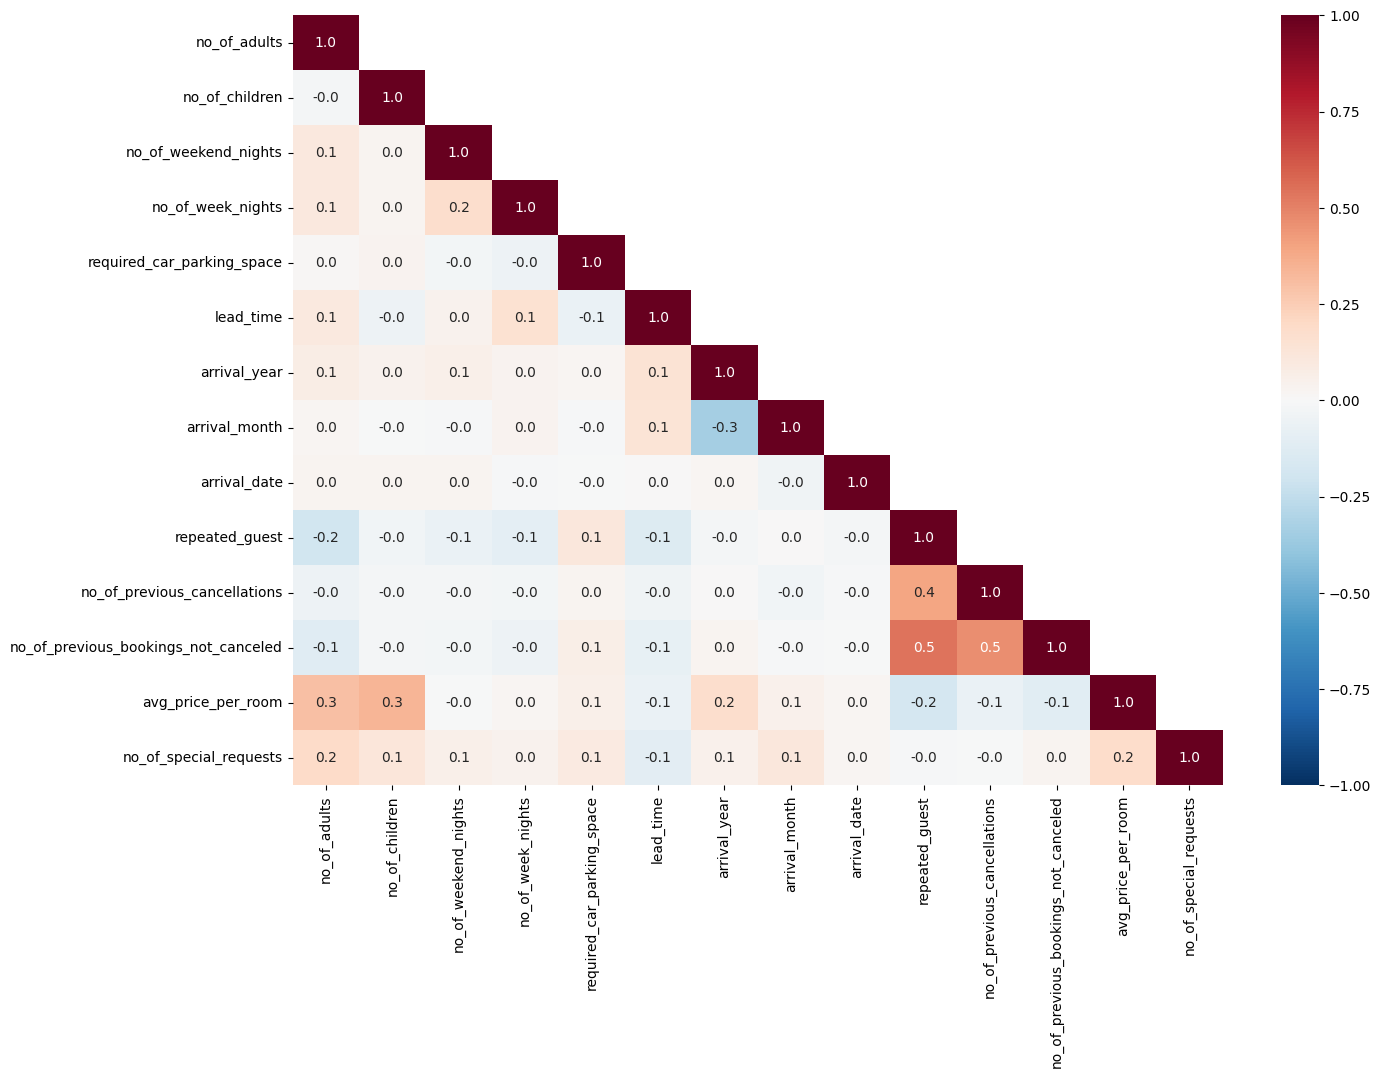

In [10]:
# Create mask
mask = np.zeros_like(corr_mat, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1,
            mask=mask)

We see from the correlation matrix above, that there is not a lot of correlation between the different features. The highest correlations happen between:
- repeated_guest & no_of_previous_bookings_not_canceled
- no_of_previous_cancellations & no_of_previous_bookings_not_canceled
- no_of_previous_cancellations & repeated_guest

__Let's see which 5 features Recursive Feature Elimination selects__

1. Make a copy of y and convert into numerical with sklearn's LabelEncoder

In [11]:
from sklearn.preprocessing import LabelEncoder

lencoder = LabelEncoder()

y_encoded = y.copy()
y_encoded = pd.DataFrame(lencoder.fit_transform(y_encoded))

In [12]:
print(y_encoded.head())

   0
0  1
1  1
2  0
3  0
4  0


2.1 Get the 5 most important features for defining the cancellation status according th sklear's Recursive Feature Elimination using LinearRegression as our estimator

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=5, step=1)
selector = rfe.fit(X_train.select_dtypes(exclude='object'), y_encoded)
selectedFeatures = list(
    X_train.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['no_of_adults',
 'required_car_parking_space',
 'arrival_year',
 'repeated_guest',
 'no_of_special_requests']

According to the RFE , the most important features are: `no_of_adults`, `required_car_parking_space`, `arrival_year`,`repeated_guest` & `no_of_special_request`

Let's have a look at these:

##### __Number of Adults__

<AxesSubplot: xlabel='no_of_adults', ylabel='Count'>

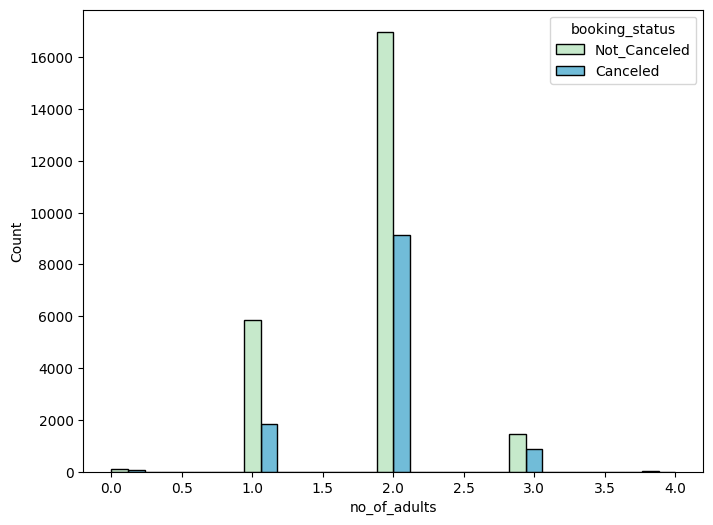

In [36]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='no_of_adults', hue='booking_status', multiple='dodge', palette='GnBu')

In [21]:
print(data.loc[data['booking_status'] == 'Canceled'].no_of_adults.value_counts())
print('--------------')
print(data.loc[data['booking_status'] == 'Not_Canceled'].no_of_adults.value_counts())

2    9119
1    1856
3     863
0      44
4       3
Name: no_of_adults, dtype: int64
--------------
2    16989
1     5839
3     1454
0       95
4       13
Name: no_of_adults, dtype: int64


* `no_of_adults` takes on 5 different values. 0, 1, 2, 3, 4
* Out of the 11885 people that cancel their bookings, 77% consist of two adults and 15.6% of one adult
* Out of the 24390 people that didn't cancel their bookings, 69.7% where two adults and 23.9% of one adult

Let's investigate if this is telling or simply due to the fact that most reservations consist of 1 & 2 adults (makes sense)

In [24]:
data.no_of_adults.value_counts()

2    26108
1     7695
3     2317
0      139
4       16
Name: no_of_adults, dtype: int64

As expected, out of the 36275 reservations, 72% consisted of 2 adults and 21.2% consisted of one adult. The previous results make sense then.

##### __required_car_parking_space__

In [31]:
data.required_car_parking_space.value_counts()

0    35151
1     1124
Name: required_car_parking_space, dtype: int64

<AxesSubplot: xlabel='required_car_parking_space', ylabel='Count'>

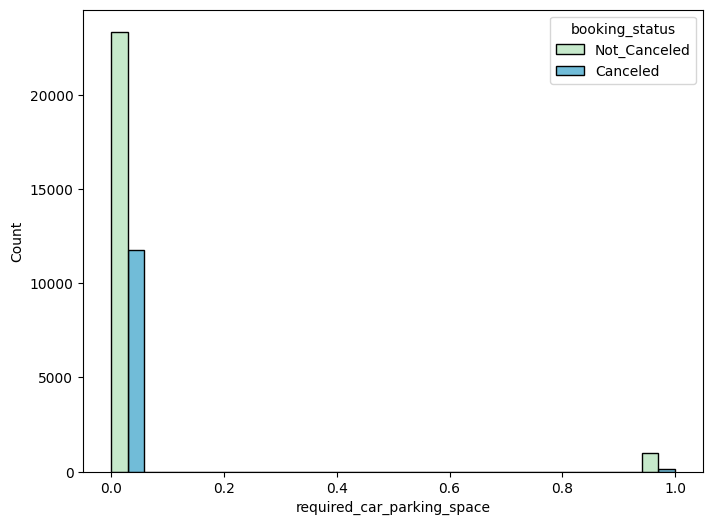

In [33]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='required_car_parking_space', hue='booking_status', multiple='dodge', palette='GnBu')

##### __arrival_year__

In [37]:
data.arrival_year.value_counts()

2018    29761
2017     6514
Name: arrival_year, dtype: int64

<AxesSubplot: xlabel='arrival_year', ylabel='Count'>

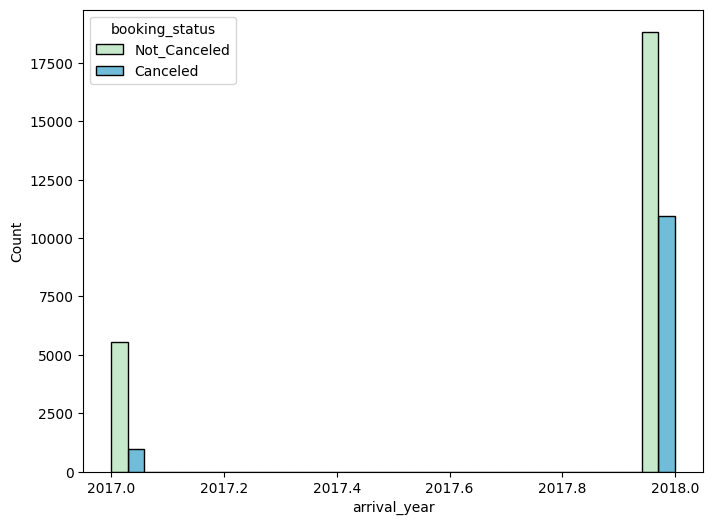

In [39]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='arrival_year', hue='booking_status', multiple='dodge', palette='GnBu')

##### __repeated_guest__

In [40]:
data.repeated_guest.value_counts()

0    35345
1      930
Name: repeated_guest, dtype: int64

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='repeated_guest', hue='booking_status', multiple='dodge', palette='GnBu')

##### __no_of_special_requests__

In [46]:
data.no_of_special_requests.value_counts()

0    19777
1    11373
2     4364
3      675
4       78
5        8
Name: no_of_special_requests, dtype: int64

<AxesSubplot: xlabel='no_of_special_requests', ylabel='Count'>

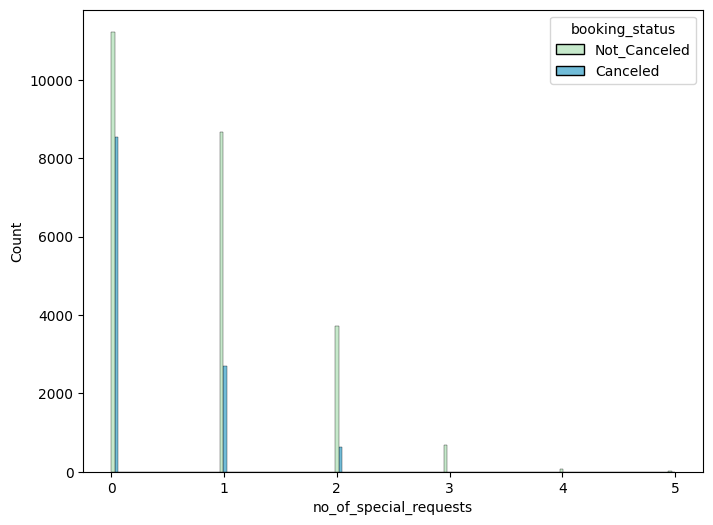

In [47]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='no_of_special_requests', hue='booking_status', multiple='dodge', palette='GnBu')

#### __2.3 Categorical Features__

In [50]:
cat_features = data.select_dtypes(include='object')

In [51]:
cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Booking_ID           36275 non-null  object
 1   type_of_meal_plan    36275 non-null  object
 2   room_type_reserved   36275 non-null  object
 3   market_segment_type  36275 non-null  object
 4   booking_status       36275 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


##### __type_of_meal_plan__

In [52]:
data.type_of_meal_plan.value_counts()

Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

<AxesSubplot: xlabel='type_of_meal_plan', ylabel='Count'>

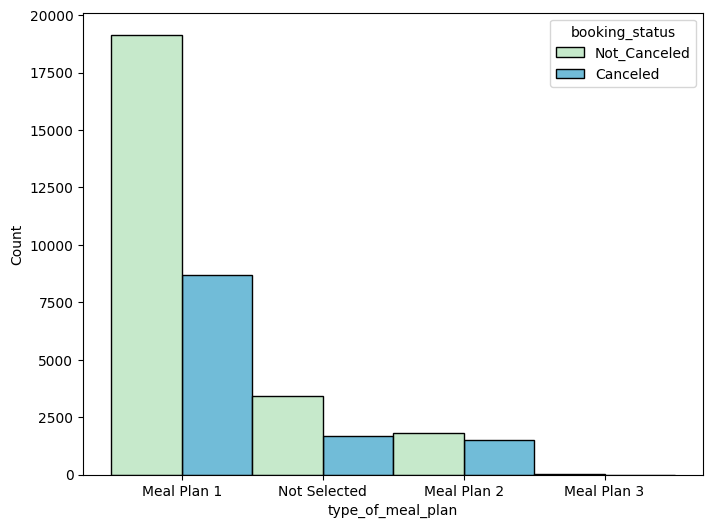

In [53]:
plt.figure(figsize=(8,6))
sns.histplot(data=data, x='type_of_meal_plan', hue='booking_status', multiple='dodge', palette='GnBu')

##### __room_type_reserved__

In [54]:
data.room_type_reserved.value_counts()

Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

<AxesSubplot: xlabel='room_type_reserved', ylabel='Count'>

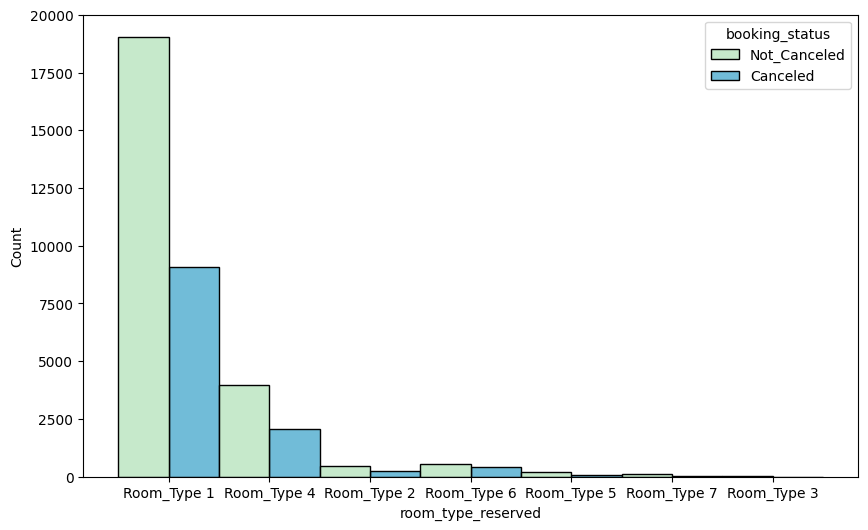

In [56]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='room_type_reserved', hue='booking_status', multiple='dodge', palette='GnBu')

##### __market_segment_type__

In [57]:
data.market_segment_type.value_counts()

Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

<AxesSubplot: xlabel='market_segment_type', ylabel='Count'>

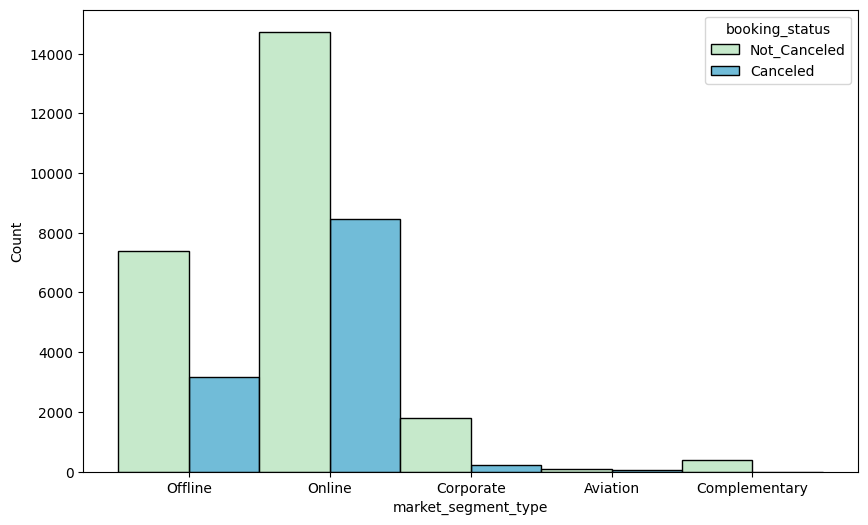

In [59]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='market_segment_type', hue='booking_status', multiple='dodge', palette='GnBu')

### __3. Data Preprocessing and Feature Engineering__

* Due to the nature of the dataset we don't have outliers or missing values
* Let's jump directly into encoding the categorical features to transform them into numerical

In [81]:
cat_reduced = cat_features[['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']]

meal_plan = cat_features[['type_of_meal_plan']]
room_type = cat_features[['room_type_reserved']]
market_segment = cat_features[['market_segment_type']]

meal_plan = pd.DataFrame(lencoder.fit_transform(np.array(meal_plan).ravel()))
room_type = pd.DataFrame(lencoder.fit_transform(np.array(room_type).ravel()))
market_segment = pd.DataFrame(lencoder.fit_transform(np.array(market_segment).ravel()))


In [82]:
cat_encoded = pd.concat([meal_plan, room_type, market_segment], axis=1)

cat_encoded.columns = cat_reduced.columns

In [83]:
cat_encoded.head()

,type_of_meal_plan,room_type_reserved,market_segment_type
0,0,0,3
1,3,0,4
2,0,0,4
3,0,0,4
4,3,0,4


In [77]:
X_train.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0


In [86]:
temp = X_train.select_dtypes(exclude='object')

X = pd.concat([temp, cat_encoded], axis=1)
y = y_encoded

In [85]:
X.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,room_type_reserved,market_segment_type
0,2,0,1,2,0,224,2017,10,2,0,0,0,65.00,0,0,0,3
1,2,0,2,3,0,5,2018,11,6,0,0,0,106.68,1,3,0,4
2,1,0,2,1,0,1,2018,2,28,0,0,0,60.00,0,0,0,4
3,2,0,0,2,0,211,2018,5,20,0,0,0,100.00,0,0,0,4
4,2,0,1,1,0,48,2018,4,11,0,0,0,94.50,0,3,0,4


In [87]:
y.head()

,0
0,1
1,1
2,0
3,0
4,0


### __3. Modeling__

In [163]:
# Let's create a train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### __3.1 Random Forest Classifier__

In [213]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, np.array(y_train).ravel())
y_pred_rfc = rfc.predict(X_test)

In [165]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1937  464]
 [ 225 4629]]


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      2401
           1       0.91      0.95      0.93      4854

    accuracy                           0.91      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.91      0.90      7255



##### __3.2 Logistic Regression__

In [212]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, np.array(y_train).ravel())
y_pred_lr = clf_lr.predict(X_test)

In [167]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1442  959]
 [ 481 4373]]


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67      2401
           1       0.82      0.90      0.86      4854

    accuracy                           0.80      7255
   macro avg       0.79      0.75      0.76      7255
weighted avg       0.80      0.80      0.80      7255



##### __3.3 Support Vector Machines__

In [214]:
from sklearn import svm

clf_svc = svm.SVC().fit(X_train, np.array(y_train).ravel())
y_pred_svc = clf_svc.predict(X_test)

In [169]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 993 1408]
 [ 307 4547]]


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.41      0.54      2401
           1       0.76      0.94      0.84      4854

    accuracy                           0.76      7255
   macro avg       0.76      0.68      0.69      7255
weighted avg       0.76      0.76      0.74      7255



##### __3.4 Stochastic Gradient Descent__

In [215]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, np.array(y_train).ravel())
y_pred_sgd = sgd_clf.predict(X_test)

In [171]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[2392    9]
 [4453  401]]


Classification Report:
               precision    recall  f1-score   support

           0       0.35      1.00      0.52      2401
           1       0.98      0.08      0.15      4854

    accuracy                           0.38      7255
   macro avg       0.66      0.54      0.33      7255
weighted avg       0.77      0.38      0.27      7255



Random Forest Classifier Algorithm works the best by far reaching an accuracy of 91%

### __4. Hyper-Parameter Tuning__

In [175]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [176]:
rfc = RandomForestClassifier()

In [177]:
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [178]:
# Create a GridSearchCV and RandomizedSearchCV object
grid_search = GridSearchCV(rfc, params, cv=5) # for GridSearchCV
random_search = RandomizedSearchCV(rfc, params, cv=5) # for RandomizedSearchCV

In [180]:
# Fit the search object on the training data
grid_search.fit(X_train, np.array(y_train).ravel()) # for GridSearchCV
random_search.fit(X_train, np.array(y_train).ravel()) # for RandomizedSearchCV

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 10, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100]})

In [194]:
# Retrieve the best hyperparameters and the best score:
best_params_gs = grid_search.best_params_ # for GridSearchCV
best_params_rs = random_search.best_params_ # for RandomizedSearchCV

best_score_gs = grid_search.best_score_ # for GridSearchCV
best_score_rs = random_search.best_score_ # for RandomizedSearchCV

best_params_gs

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [193]:
# Use best hyperparameters to fit the model
best_rfc = RandomForestClassifier(**best_params_gs)

best_rfc.fit(X_train, np.array(y_train).ravel())

RandomForestClassifier(max_depth=50)

In [192]:
test_score = best_rfc.score(X_test, y_test)
print(test_score)

0.9040661612680909


In [190]:
y_pred = best_rfc.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1943  458]
 [ 226 4628]]


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85      2401
           1       0.91      0.95      0.93      4854

    accuracy                           0.91      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.91      0.91      0.90      7255



The hyperparameter optimization didn't really improve my model. I am happy with 91%!

In [219]:
y_pred_prob_rf = best_rfc.predict_proba(X_test)[:, 1]
y_pred_prob_lr = clf_lr.predict_proba(X_test)[:, 1]

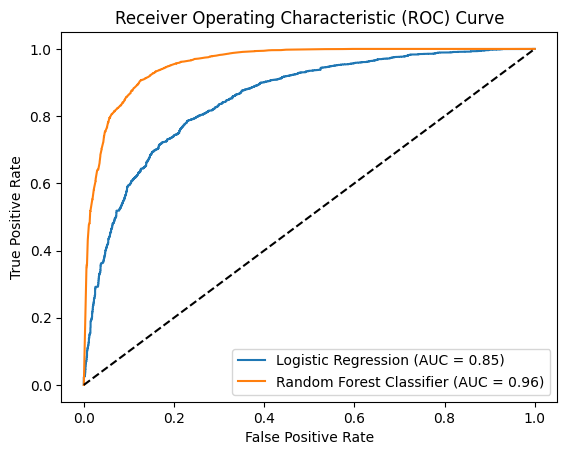

In [224]:
from sklearn.metrics import roc_curve, roc_auc_score

# y_pred_prob is an array of predicted probabilities for the positive class
# y_true is an array of true labels for the positive class
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob_lr, pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob_rf, pos_label=1)

# calculate AUC (Area Under the Curve)
auc1 = roc_auc_score(y_test, y_pred_prob_lr)
auc2 = roc_auc_score(y_test, y_pred_prob_rf)

plt.plot(fpr1, tpr1, label='Logistic Regression (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Random Forest Classifier (AUC = %0.2f)' % auc2)
         
# plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')


plt.savefig('sdf.png')

plt.show()

# # plot the ROC curve
# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
# plt.plot([0, 1], [0, 1], 'k--') # plot the random guess line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()
